In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers



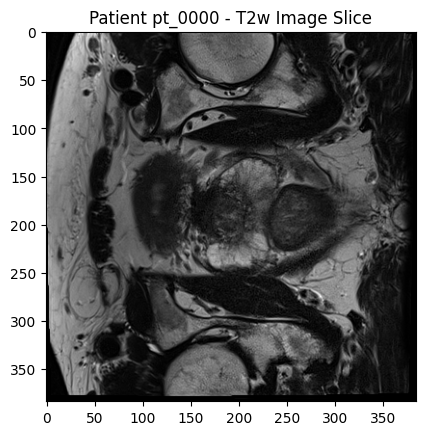

In [2]:
# Function to load NIfTI images for a patient
def load_nifti_images(patient_id, data_dir):
    t2w_file = os.path.join(data_dir, f'{patient_id}', 't2w.nii')
    adc_file = os.path.join(data_dir, f'{patient_id}', 'adc.nii')
    ktrans_file = os.path.join(data_dir, f'{patient_id}', 'ktrans.nii')

    t2w_img = nib.load(t2w_file).get_fdata()
    adc_img = nib.load(adc_file).get_fdata()
    ktrans_img = nib.load(ktrans_file).get_fdata()

    return t2w_img, adc_img, ktrans_img

patient_id = 'pt_0000'
data_dir = 'data/mri'
t2w_img, adc_img, ktrans_img = load_nifti_images(patient_id, data_dir)

plt.imshow(t2w_img[:, :, t2w_img.shape[2] // 2], cmap='gray')
plt.title(f'Patient {patient_id} - T2w Image Slice')
plt.show()


In [3]:
# Load labels from info.csv
csv_file = 'data/info.csv'
df = pd.read_csv(csv_file)

print(df.head())

df = df[['pt_id', 'ijk', 'label']]  


   index    pt_id Name  fid         ijk           Dim  label
0      1  pt_0000  t2w    1   167 224 9  384x384x19x1   True
1      2  pt_0001  t2w    1  157 186 10  384x384x19x1  False
2      3  pt_0002  t2w    2  203 216 10  384x384x19x1  False
3      4  pt_0002  t2w    1  154 217 12  384x384x19x1   True
4      5  pt_0003  t2w    1  240 205 12  384x384x21x1  False


In [4]:
def extract_finding_with_padding(ijk, img, target_size=32):
    i, j, k = [int(x) for x in ijk.split()]  
    
    half_size = target_size // 2

    # Extract sub-region around the finding
    extracted_img = img[max(i-half_size, 0):i+half_size, max(j-half_size, 0):j+half_size, max(k-half_size, 0):k+half_size]
    
    # Determine the actual shape of the extracted image
    actual_shape = extracted_img.shape

    # Padding each axis to reach the target size
    pad_x = target_size - actual_shape[0]
    pad_y = target_size - actual_shape[1]
    pad_z = target_size - actual_shape[2]
    
    # Apply padding
    padded_img = np.pad(extracted_img, 
                        ((0, pad_x), (0, pad_y), (0, pad_z)), 
                        mode='constant', constant_values=0)
    
    return padded_img

ijk = '50 60 40'  
finding_img = extract_finding_with_padding(ijk, t2w_img)

print(f'Shape of the padded finding: {finding_img.shape}')


Shape of the padded finding: (32, 32, 32)


In [5]:
print(len(finding_img))

32


In [6]:
findings_data = []
labels = []

for index, row in df.iterrows():
    patient_id = str(row['pt_id']).zfill(4)
    ijk = row['ijk']
    label = row['label']

    # Load MRI images
    t2w_img, adc_img, ktrans_img = load_nifti_images(patient_id, data_dir)
    
    t2w_finding = extract_finding_with_padding(ijk, t2w_img)
    adc_finding = extract_finding_with_padding(ijk, adc_img)
    ktrans_finding = extract_finding_with_padding(ijk, ktrans_img)

    # Stack the three images (T2w, ADC, Ktrans) into a 3D array
    finding_combined = np.stack([t2w_finding, adc_finding, ktrans_finding], axis=-1)
    
    findings_data.append(finding_combined)
    labels.append(label)

X = np.array(findings_data)
y = np.array(labels)

# Normalize the pixel values
X = X / np.max(X)

# Convert labels to binary
y = to_categorical(y)

# Split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')


Shape of X_train: (260, 32, 32, 32, 3)
Shape of y_train: (260, 2)


In [7]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

260
260
66
66


In [8]:
print(len(findings_data))  
print(len(findings_data[0]))  
print(len(findings_data[0][0]))  
print(len(findings_data[0][0][0]))


326
32
32
32


In [9]:
log_dir = os.path.join("logs", "fit", datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True)



In [10]:
# CNN Model for 3D MRI Data
model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(32, 32, 32, 3)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Flatten(),
    # Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')  # 2 output neurons for two classes (CS-PCa or not)
])

# model = Sequential([
#     Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(32, 32, 32, 3)),
#     MaxPooling3D(pool_size=(2, 2, 2)),
#     Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
#     MaxPooling3D(pool_size=(2, 2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),  # Dropout to reduce overfitting
#     Dense(1, activation='sigmoid')
# ])




# 1st Convolutional Layer
# model.add(Conv3D(32, (3, 3, 3), activation='relu', input_shape=(32, 32, 32, 3)))  # 32x32x32 with 3 channels
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# # 2nd Convolutional Layer
# model.add(Conv3D(64, (3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# # 3rd Convolutional Layer
# model.add(Conv3D(128, (3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# # Flatten and Fully Connected Layers
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))  # Binary classification

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



model.summary()


C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 30, 30, 30, 32) │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 15, 15, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 108000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,912,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,918,978 (26.39 MB)

 Trainable params: 6,918,978 (26.39 MB)

 Non-trainable params: 0 (0.00 B)

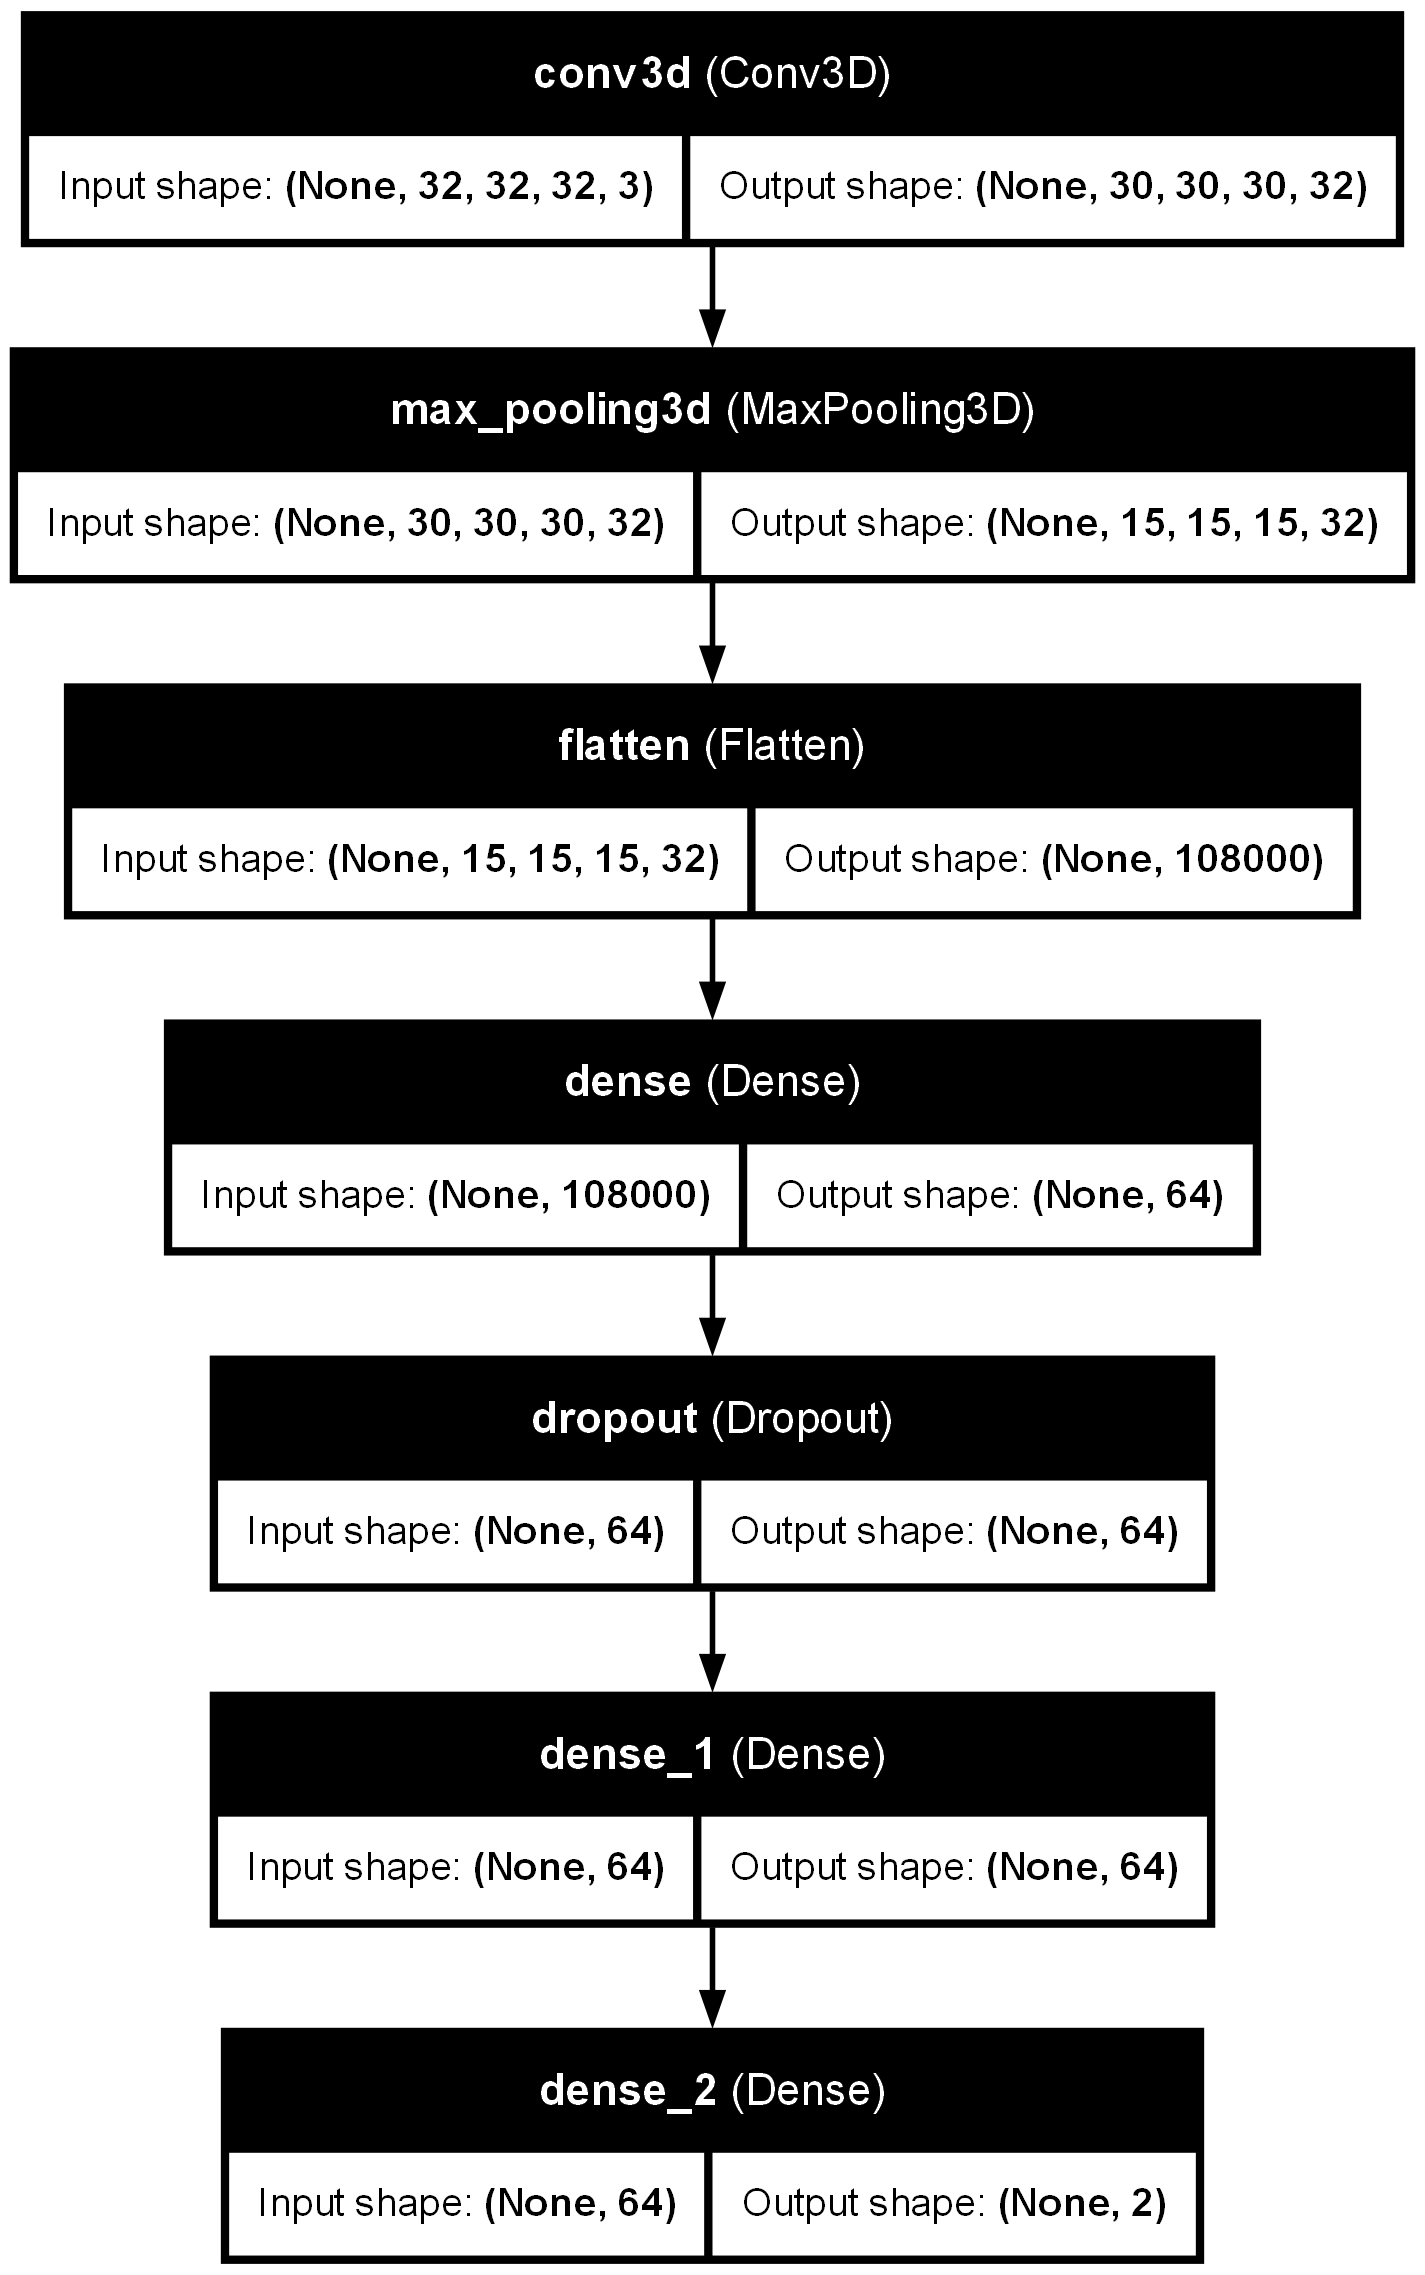

In [11]:
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32, callbacks=[tensorboard_callback])

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 503ms/step - accuracy: 0.6673 - loss: 1.6441 - val_accuracy: 0.7424 - val_loss: 0.6831
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 405ms/step - accuracy: 0.7286 - loss: 0.6755 - val_accuracy: 0.7424 - val_loss: 0.6735
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - accuracy: 0.7520 - loss: 0.6179 - val_accuracy: 0.7424 - val_loss: 0.6833
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7775 - loss: 0.5796 - val_accuracy: 0.7424 - val_loss: 0.6861
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - accuracy: 0.7791 - loss: 0.5890 - val_accuracy: 0.7424 - val_loss: 0.6821
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 391ms/step - accuracy: 0.7675 - loss: 0.5563 - val_accuracy: 0.7424 - val_loss: 0.7324
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step - accuracy: 0.7542 - loss: 0.5581 - val_accuracy: 0.7424 - val_loss: 0.7368
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 0.7599 - loss: 0.5039 - val_accuracy: 0.7424 - val_loss: 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6114 - loss: 3.5286
Test Accuracy: 0.6212121248245239


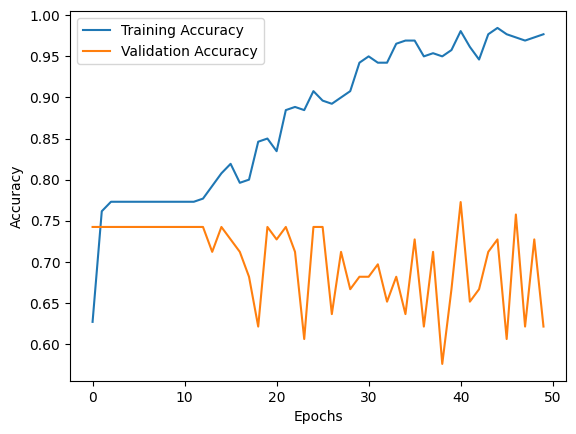

In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
